This notebook uses Tensorflow and CNN to finetune VGG16, a pretrained image classification model.

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import MaxPooling2D
from keras.layers import GlobalMaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import Dropout
from keras.applications import *
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import os
from PIL import Image
import cv2

In [2]:
# %matplotlib inline
# import matplotlib.pyplot as plt
# from IPython.display import clear_output
# # from tensorflow.keras.models import Sequential
# # from tensorflow.keras.layers import Dense
# from sklearn.preprocessing import minmax_scale
# from sklearn.metrics import confusion_matrix, classification_report
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.datasets import make_classification
# import numpy as np
# import seaborn as sns
# import matplotlib as mpl
# import pandas as pd
# mpl.rcParams['figure.dpi']=100

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
%cd /content/drive/MyDrive/DataSpikeFolder

/content/drive/.shortcut-targets-by-id/17hBStt627ZzpuCOKhHeNMxcSth_XTsZG/DataSpikeFolder


**Read all images from the stored data splits**

In [5]:
train = pd.read_csv("train.csv")
print(train.shape)

valid = pd.read_csv("valid.csv")
print(valid.shape)

test = pd.read_csv("test.csv")
print(test.shape)

(2591, 2)
(230, 2)
(8, 2)


In [6]:
# Filter rows based on file extensions
extensions = ['.jpg', '.jpeg', '.png']

train = train[train['Path'].str.lower().str.endswith(tuple(extensions))]
print(train.shape)

valid = valid[valid['Path'].str.lower().str.endswith(tuple(extensions))]
print(valid.shape)

test = test[test['Path'].str.lower().str.endswith(tuple(extensions))]
print(test.shape)

(2590, 2)
(230, 2)
(8, 2)


In [7]:
train = train.reset_index(drop=True)
valid = valid.reset_index(drop=True)
test = test.reset_index(drop=True)

In [8]:
print(test)

                                    Path     Label
0  dataset/MICC-F2000/DSC_1426_scale.jpg  original
1  dataset/MICC-F2000/DSC_1034_scale.jpg  original
2   dataset/MICC-F2000/PA260237tamp8.jpg  tampered
3   dataset/MICC-F2000/DSCF1853tamp6.jpg  tampered
4   dataset/MICC-F2000/DSCF1853tamp8.jpg  tampered
5   dataset/MICC-F2000/DSC_0409tamp1.jpg  tampered
6  dataset/MICC-F2000/DSC_0973_scale.jpg  original
7   dataset/MICC-F2000/DSCF0201tamp4.jpg  tampered


**Below is the data preprocessing step for the Train and validation data path using OpenCV and TensorFlow to read, resize, normalize and convert all images to a TensorFlow tensor format.**

In [9]:
x = []
dim = (128,128)
for i in tqdm(train["Path"]):
  try:
    img = cv2.imread('.'+'/{}'.format(i))
    if len(img.shape) > 2 and img.shape[2] == 4:
        # convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, dim)
    # normalise the images
    img = img/255
    img_to_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
  except:
    print(i)
  x.append(img_to_tensor)

trainX_tensor = tf.stack(x)

100%|██████████| 2590/2590 [1:02:55<00:00,  1.46s/it]


In [10]:
x = []
dim = (128,128)
for i in tqdm(valid["Path"]):
  try:
    img = cv2.imread('.'+'/{}'.format(i))
    if len(img.shape) > 2 and img.shape[2] == 4:
        # convert the image from RGBA2RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGRA2BGR)
    img = cv2.resize(img, dim)
    # normalise the images
    img = img/255
    img_to_tensor = tf.convert_to_tensor(img, dtype=tf.float32)
  except:
    print(i)
  x.append(img_to_tensor)

validX_tensor = tf.stack(x)

100%|██████████| 230/230 [05:49<00:00,  1.52s/it]


In [11]:
# Convert labels to numeric values (assuming 0 for negative class and 1 for positive class)
train['Label'] = train['Label'].apply(lambda label: 1 if label == 'original' else 0)
valid['Label'] = valid['Label'].apply(lambda label: 1 if label == 'original' else 0)

# Convert labels to TensorFlow tensor
trainY = tf.convert_to_tensor(train['Label'].values, dtype=tf.float32)
validY = tf.convert_to_tensor(valid['Label'].values, dtype=tf.float32)

In [12]:
validY

<tf.Tensor: shape=(230,), dtype=float32, numpy=
array([1., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 0., 1., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1.,
       1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1.,
       0., 0., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1.,
       1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1.,
       0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0., 0., 1., 0., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1.,
       1., 0., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
       0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1.,
       1., 0., 1., 0., 0., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1

In [13]:
from keras.applications import VGG16
from keras.layers import Dropout

## adopt transfer learning by setting finetuning the top layers of the pretranined VGG16 model
base_model = VGG16(include_top=False,
                   weights='imagenet',
                   input_shape=(128,128,3))

model = Sequential()
model.add(BatchNormalization(input_shape=(128,128,3)))

model.add(base_model)
model.add(Flatten())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

model.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 128, 128, 3)      12        
 ormalization)                                                   
                                                                 
 vgg16 (Functional)          (None, 4, 4, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 8192)              0         
                                                                 
 dropout (Dropout)           (None, 8192)              0         
                                                                 
 dense (Dense)               (None, 1)                 8193      
                                                                 
Total params: 14,722,893
Trainable params: 14,722,887
Non

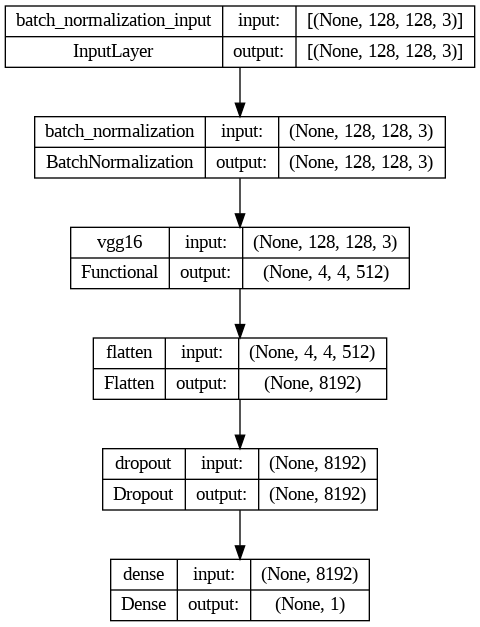

In [14]:
from keras.utils.vis_utils import plot_model
plot_model(model, show_shapes=True, show_layer_names=True)

In [15]:
from keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

opt  = SGD(learning_rate=0.001)

model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])

# Create the 'baseline/weights/vgg16_best_baseline.h5' file
with open('baseline/weights/vgg16_best_baseline.h5', 'w') as f:
  pass

callbacks = [EarlyStopping(monitor='val_loss', patience=3, verbose=0),
                ModelCheckpoint(filepath='baseline/weights/vgg16_best_baseline.h5',
                                 save_best_only=True,
                                 save_weights_only=True)]

In [16]:
batch_size = 8
## Model training
history = model.fit(x=trainX_tensor, y=trainY, validation_data=(validX_tensor, validY),
                  batch_size=batch_size,verbose=2, callbacks=callbacks, epochs=15)

Epoch 1/15
324/324 - 33s - loss: 0.4598 - accuracy: 0.8023 - val_loss: 0.2866 - val_accuracy: 0.9130 - 33s/epoch - 101ms/step
Epoch 2/15
324/324 - 19s - loss: 0.2682 - accuracy: 0.9108 - val_loss: 0.3041 - val_accuracy: 0.9000 - 19s/epoch - 59ms/step
Epoch 3/15
324/324 - 20s - loss: 0.2185 - accuracy: 0.9297 - val_loss: 0.2474 - val_accuracy: 0.9261 - 20s/epoch - 60ms/step
Epoch 4/15
324/324 - 19s - loss: 0.1874 - accuracy: 0.9409 - val_loss: 0.1841 - val_accuracy: 0.9739 - 19s/epoch - 60ms/step
Epoch 5/15
324/324 - 18s - loss: 0.1787 - accuracy: 0.9425 - val_loss: 0.1976 - val_accuracy: 0.9609 - 18s/epoch - 56ms/step
Epoch 6/15
324/324 - 19s - loss: 0.1653 - accuracy: 0.9429 - val_loss: 0.1754 - val_accuracy: 0.9609 - 19s/epoch - 60ms/step
Epoch 7/15
324/324 - 20s - loss: 0.1584 - accuracy: 0.9525 - val_loss: 0.1748 - val_accuracy: 0.9739 - 20s/epoch - 61ms/step
Epoch 8/15
324/324 - 19s - loss: 0.1466 - accuracy: 0.9486 - val_loss: 0.2084 - val_accuracy: 0.9696 - 19s/epoch - 57ms/step

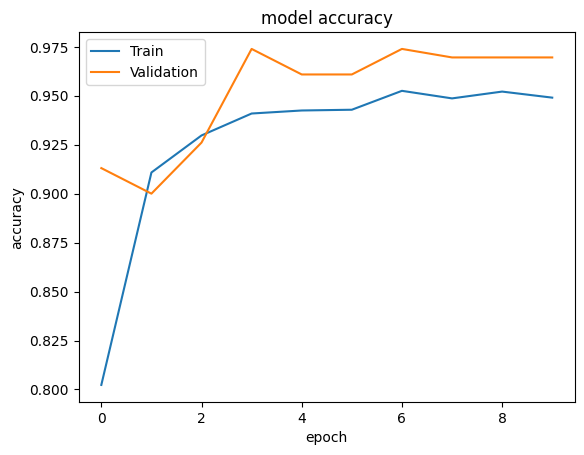

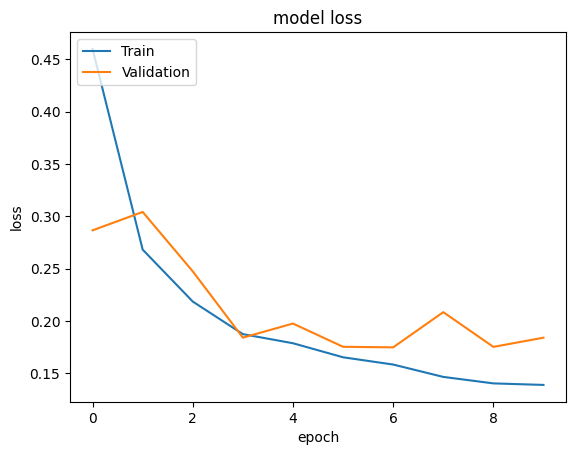

In [17]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [18]:
import timeit
# Reload the model
# model = keras.models.load_model('baseline/weights/best_baseline.h5')

# Load the image
for image in test["Path"]:
  img = cv2.imread(image)
  img = cv2.resize(img, (128, 128))
  img = img / 255.0
  img = tf.expand_dims(img, axis=0)

  # Get the inference time
  start_time = timeit.default_timer()
  predictions = model.predict(img)
  end_time = timeit.default_timer()
  inference_time = end_time - start_time

  # Print the inference time
  print(f'The inference time is: {inference_time:.2f} ms')

  # Get the predicted class
  predicted_class = predictions[0][0]

  # Print the predicted class
  print(f'The predicted class for {image} is: {predicted_class}')

1/1 [==============================] - 3s 3s/step
The inference time is: 2.76 ms
The predicted class for dataset/MICC-F2000/DSC_1426_scale.jpg is: 0.9197361469268799
1/1 [==============================] - 0s 20ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/DSC_1034_scale.jpg is: 0.9410764575004578
1/1 [==============================] - 0s 20ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/PA260237tamp8.jpg is: 0.01961100473999977
1/1 [==============================] - 0s 20ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp6.jpg is: 0.3367876410484314
1/1 [==============================] - 0s 20ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/DSCF1853tamp8.jpg is: 0.22260117530822754
1/1 [==============================] - 0s 20ms/step
The inference time is: 0.06 ms
The predicted class for dataset/MICC-F2000/DSC_0409tamp1.jpg is: 0.0337839871644